<a href="https://colab.research.google.com/github/MargaretZhou/MISA-Bootcamp-2021/blob/main/Santa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import keras
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import os
from glob import glob

# Connect to Google Drive to access data

Note sure how else to access data besides using Google Drive. But you can upload data into drive, mount drive and access data from drive.

Already created a data folder called 432DeepLearning_SantaData. Link here:
https://drive.google.com/drive/u/0/folders/1N0cZ-UM4h124fx6l4SRpmOcKkfGlnmuA

In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


# Load Data

### For EDA

In [ ]:
train_dir = './drive/MyDrive/432DeepLearning_SantaData/is_that_santa/train' # train image folder
test_dir = './drive/MyDrive/432DeepLearning_SantaData/is_that_santa/test' # test image folder

# get the list of jpegs from sub image class folders
santa_train = [fn for fn in os.listdir(f'{train_dir}/santa') if fn.endswith('.jpg')]
nonsanta_train = [fn for fn in os.listdir(f'{train_dir}/not-a-santa') if fn.endswith('.jpg')]
santa_test = [fn for fn in os.listdir(f'{test_dir}/santa') if fn.endswith('.jpg')]
nonsanta_test = [fn for fn in os.listdir(f'{test_dir}/not-a-santa') if fn.endswith('.jpg')]

# Can load data later

### For modeling

Images are augmented

In [ ]:
train_generator = ImageDataGenerator(rescale = 1/255)
test_generator = ImageDataGenerator(rescale = 1/255)

In [ ]:
trainset = train_generator.flow_from_directory(r"./drive/MyDrive/432DeepLearning_SantaData/is_that_santa/train",target_size = (150,150),class_mode='binary',batch_size=80)
testset = test_generator.flow_from_directory(r"./drive/MyDrive/432DeepLearning_SantaData/is_that_santa/test",target_size = (150,150),class_mode = 'binary',batch_size= 20)

Found 614 images belonging to 2 classes.
Found 616 images belonging to 2 classes.


# EDA on train

Source: https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

### Train and test length for each class

Completely balanced

In [ ]:
# check the number of files in train
len(santa_train), len(nonsanta_train)

(308, 308)

In [ ]:
# check the number of files in test
len(santa_test), len(nonsanta_test)

(308, 308)

### Take a look at a few samples from santa and nonsanta class

Few priests in test set look awfully like santas

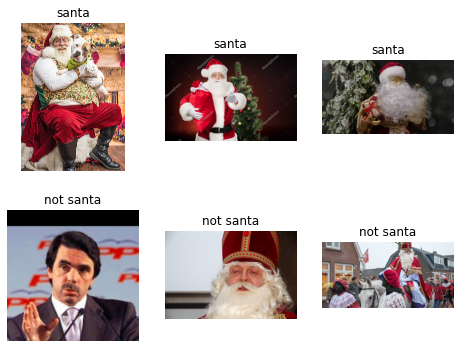

In [ ]:
# randomly select 3 of each
select_santa = np.random.choice(santa_train, 3, replace = False)
select_nonsanta = np.random.choice(nonsanta_train, 3, replace = False)

# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/santa/{select_santa[i]}'
        label = 'santa'
    else:
        fp = f'{train_dir}/not-a-santa/{select_nonsanta[i-3]}'
        label = 'not santa'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp)
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

### Turn images into matrix based on pixels (numpy array)

In [ ]:
# making n X m matrix
def img2np(path, list_of_filename, size = (100, 100)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size)
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
santa_pixels_train = img2np(f'{train_dir}/santa/', santa_train)
nonsanta_pixels_train = img2np(f'{train_dir}/not-a-santa/', nonsanta_train)

### Get image average

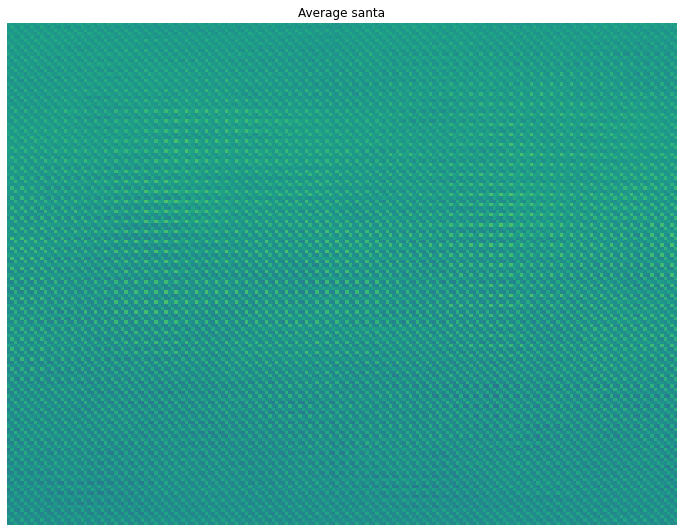

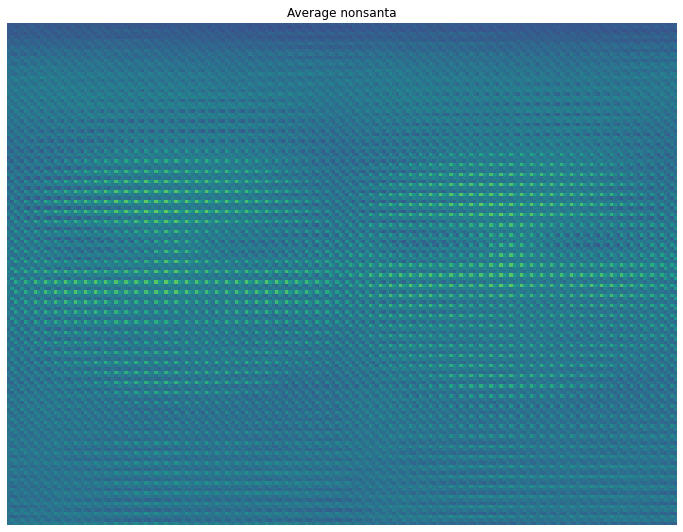

In [ ]:

def find_mean_img(full_mat, title, size = (150, 200)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255)
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

santa_mean = find_mean_img(santa_pixels_train, 'santa')
nonsanta_mean = find_mean_img(nonsanta_pixels_train, 'nonsanta')

### Contrast between images

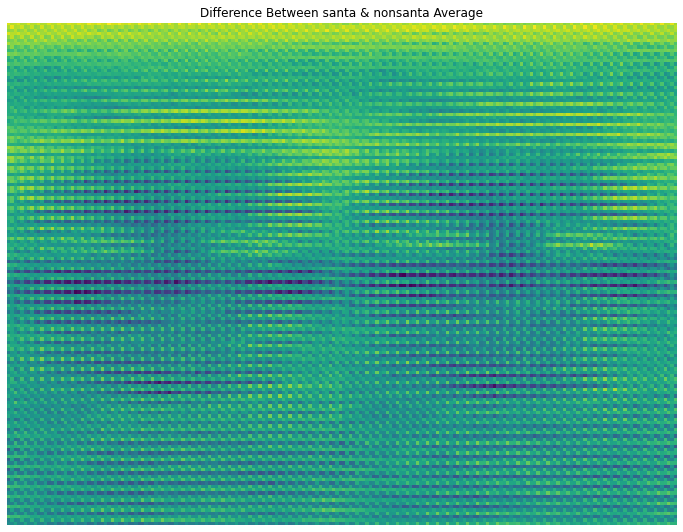

In [ ]:
contrast_mean = santa_mean - nonsanta_mean
plt.imshow(contrast_mean)
plt.title(f'Difference Between santa & nonsanta Average')
plt.axis('off')
plt.show()

### Variability

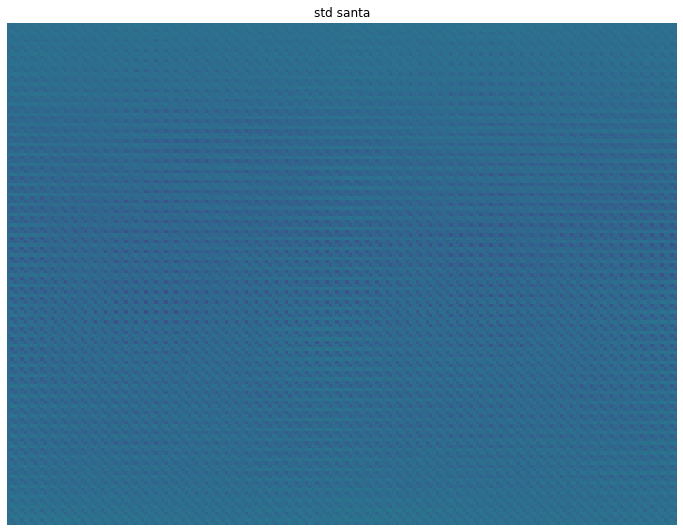

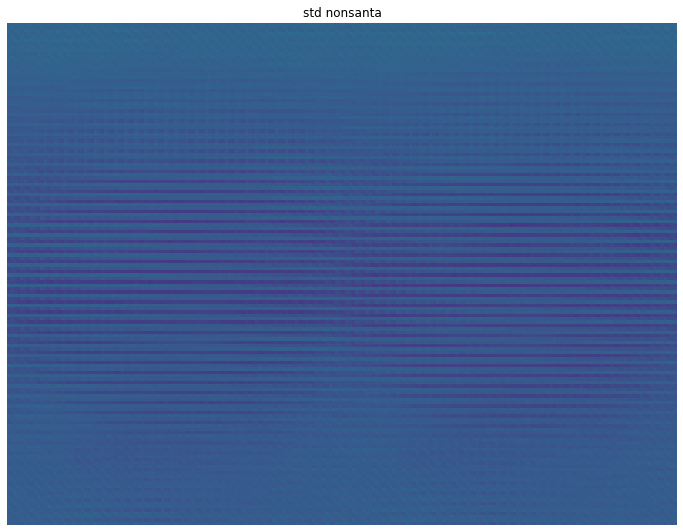

In [ ]:

def find_std_img(full_mat, title, size = (150, 200)):
    # calculate the average
    std_img = np.std(full_mat, axis = 0)
    # reshape it back to a matrix
    std_img = std_img.reshape(size)
    plt.imshow(std_img, vmin=0, vmax=255)
    plt.title(f'std {title}')
    plt.axis('off')
    plt.show()
    return std_img

santa_mean = find_std_img(santa_pixels_train, 'santa')
nonsanta_mean = find_std_img(nonsanta_pixels_train, 'nonsanta')